In [0]:
#!pip install gensim
#!pip install nltk

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import sqlite3
import string
import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

In [0]:
#!pip install kaggle
#!rm -r  kaggle  # remove directory .kaggle
#!rm -r .kaggle  # remove directory .kaggle
#!mkdir .kaggle  # create directory .kaggle
#!mkdir  kaggle  # create directory kaggle

#from google.colab import files
#files.upload()
#!cp kaggle.json ~/.kaggle/

In [0]:
import json
token = {"username":"ashwani0187","key":"f9c7f8263297d23fef670995e74ae664"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
  json.dump(token, file)   #save the token file
  
!chmod 600 /content/.kaggle/kaggle.json #change permissions
!kaggle config set -n path -v{/content/kaggle} #change directory path

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews -p /content/kaggle/amazon-fine-food-reviews

In [19]:
%cd /content/kaggle/amazon-fine-food-reviews
!ls -a

/content/kaggle/amazon-fine-food-reviews
.  ..  amazon-fine-food-reviews.zip


In [20]:
import os
os.getcwd()
!ls
!unzip /content/kaggle/amazon-fine-food-reviews/amazon-fine-food-reviews.zip

amazon-fine-food-reviews.zip
Archive:  /content/kaggle/amazon-fine-food-reviews/amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [21]:
!ls

amazon-fine-food-reviews.zip  database.sqlite  hashes.txt  Reviews.csv


In [0]:
#connecting to the database:
con = sqlite3.connect("database.sqlite")

In [36]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)

# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 'negative'
        else :
            return 'positive'
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head()


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [37]:
duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)

   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [38]:
#Finding the books data in the amazon_featured_reviews using the regex
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [39]:
#Removing the Books reviews we get below final dataframe:
print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [40]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

positive    276668
negative     50140
Name: Score, dtype: int64

In [41]:
#Text_preprocessing of the Text data, let's see how the text looks like and howw much unwanted things are there in the data:
final['Text'].values[0:2] #return array of all columns values

array(['This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!',
       'Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.'],
      dtype=object)

**Text Preprocessing : removing html tags , punctuation charcaters , alphanumeric numbers , length of words > 2 , uppercase to lowercase , removing the stop words , using the Snowball Stemmer.**

In [42]:
#  I have the final pandas dataFrame let's print it and analyze the html tags in it:
final.shape

(326808, 10)

In [43]:
#Let's print out the html tags in the final dataframe:

import re
i = 0
for sentence in final['Text'].values:
    pattern = re.compile('<.*?>')
    if(len(re.findall(pattern , sentence))):
        print(sentence)
        print(i)
        break
        
i+=1    

I wanted a treat that was accepted and well liked for my rescue animals.<br />This is the only treat that is healthy and loved by all 4 legged beings in my home!<br />It does not contain sugar or grains or silly vegetables which virtually all treats contain. Dogs, cats and ferrets are carnivores they are not cattle to eat grain or rabbits to eat vegetables, and WHYYYY do companies add sugar,beet pulp or corn syrup to carnivore foods? It is dangerous and can cause the death of an animal with diabetes.<br />It is pretty easy to break into smaller pieces for cats and kittens with weak jaws and its wonderful to use as an aid to gain the trust of an abused dog as it will not cause stomach upset when given in common sense amounts.<br />I like that it goes a long way as it costs alot to heal and maintain and train abused and rescued dogs.<br />NO minus to this product other then the price,I can not afford to use it as much as I would like.
0


In [0]:
#nltk.download("popular")

In [45]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')
print(sno.stem('tasty'))

{'shouldn', 'each', 'most', 'below', 'weren', 'nor', 'between', "needn't", 'out', 'such', "mightn't", 'their', 'be', 'my', 'hadn', "wouldn't", 'or', 'i', "shouldn't", 'before', 'for', "you'd", 'both', 'has', "shan't", 'were', 'our', 'to', 'while', "you'll", "it's", 'why', 'during', 'more', "you've", 'that', 'needn', 'shan', 'just', 'don', 'ma', 'he', 'down', 'myself', 'doing', 'having', 'where', 'them', 'm', 'into', 'ours', 'do', 'an', 'about', 'o', 'herself', 'yourselves', 'further', 'hers', 'your', 'you', 'here', 'this', 'not', 'wasn', 'can', 'should', 'it', 'over', "should've", 'aren', 'him', "hasn't", 'how', 'me', 'under', 'some', 'are', 'on', "isn't", "you're", "couldn't", 'themselves', 'his', "wasn't", 'she', 'himself', 'only', "she's", "didn't", 'mustn', 'yours', 'doesn', 'when', 'own', 'all', 'haven', 'am', 'wouldn', 'the', 've', "hadn't", 'does', 'there', 'above', 'ourselves', 'd', 'no', 'been', 'then', 'in', 'ain', 'theirs', 'any', 'same', 'what', 'had', 'but', 'than', 'other

In [46]:
#Difference between sentence tokenize and word tokenize:

from nltk.tokenize import sent_tokenize , word_tokenize
text ="this's a sent tokenize test. this is sent two. is this sent three? sent 4 is cool! Now it's your turn"
sen = sent_tokenize(text)
word_list = word_tokenize(text)
print(sen)
print(word_list)

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


["this's a sent tokenize test.", 'this is sent two.', 'is this sent three?', 'sent 4 is cool!', "Now it's your turn"]
['this', "'s", 'a', 'sent', 'tokenize', 'test', '.', 'this', 'is', 'sent', 'two', '.', 'is', 'this', 'sent', 'three', '?', 'sent', '4', 'is', 'cool', '!', 'Now', 'it', "'s", 'your', 'turn']


In [0]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.
all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [48]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape

(326808, 11)

In [0]:
#Storing the data to the database:
conn = sqlite3.connect('final_cleaned.sqlite')
c = conn.cursor()
final.to_sql('Reviews' , conn , if_exists='replace' , schema=None )
conn.close()

In [0]:
if os.path.isfile('final_cleaned.sqlite'):
    conn = sqlite3.connect('final_cleaned.sqlite')
    final_new = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")
#final_cleaned_data = final_new.drop('index',axis=0)
final_cleaned = final_new.drop(columns=['index'],inplace=False,axis=0)


In [119]:
#Now lets take 2500 around data points each of positive and negative review for faster processing the further data:

final_subset = final.groupby('Score').apply(lambda x : x.sample(frac = 0.03))
print(final['Score'].value_counts())
print(final_subset['Score'].value_counts())
print('final_subset shape is :' , final_subset.shape)

positive    276668
negative     50140
Name: Score, dtype: int64
positive    8300
negative    1504
Name: Score, dtype: int64
final_subset shape is : (9804, 11)


In [120]:

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
final_counts = cv.fit_transform(final_subset['CleanedText'].values)

print(type(final_counts))
print(final_counts.get_shape())
print(len(cv.get_feature_names()))

<class 'scipy.sparse.csr.csr_matrix'>
(9804, 12649)
12649


In [121]:
print(cv.get_feature_names()[1:100])

['aback', 'abandon', 'abba', 'abbi', 'abbrevi', 'abc', 'abd', 'abi', 'abil', 'abilit', 'abl', 'abnd', 'abnorm', 'abnoxi', 'abomin', 'aboout', 'aboth', 'aboutth', 'abroad', 'abrupt', 'abscond', 'absolut', 'absolutey', 'absolutley', 'absorb', 'absorpt', 'abstract', 'absurd', 'abunch', 'abund', 'abus', 'abysm', 'abyssinian', 'acacia', 'academi', 'acai', 'acapulco', 'acceler', 'accent', 'accentu', 'accept', 'access', 'accessor', 'accessori', 'accid', 'accident', 'acclim', 'accommod', 'accomod', 'accompani', 'accomplish', 'accord', 'account', 'accross', 'accumul', 'accur', 'accuraci', 'accus', 'accusatori', 'accustom', 'acerola', 'acesulfam', 'ach', 'achiev', 'acid', 'acidsfacilit', 'acini', 'ack', 'acm', 'acn', 'acorn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'acryl', 'act', 'actin', 'action', 'activ', 'actor', 'actress', 'actual', 'actuali', 'acupuncturist', 'acv', 'ad', 'adagio', 'adam', 'adament', 'adapt', 'add', 'addicit', 'addicitv', 'addict', 'addictivecan', 'addit', 'additio

In [0]:
# Before plotting the t-SNE plot we will perform TruncatedSVD operation the Bag of words vector so as to perform 
# the dimensionality reduction:

# Create a TSVD with 1000 dimension :
tsvd = TruncatedSVD(n_components=1000)

# Conduct TSVD on sparse matrix final_counts:
final_counts = tsvd.fit(final_counts).transform(final_counts)

In [123]:
#Let's print the properties of the truncated sparse matrix :
print(final_counts.shape)
print(type(final_counts))
print(final_counts)

(9804, 1000)
<class 'numpy.ndarray'>
[[ 8.59145617e-01 -9.77110471e-02  1.30511143e-01 ... -7.41222795e-04
  -2.04277133e-02  2.58112655e-02]
 [ 9.53921423e-01  6.83014856e-01 -3.31320795e-01 ...  3.43192333e-02
   6.73371102e-02  3.74872493e-02]
 [ 1.98966868e+00 -2.41778554e-01  1.03304749e-02 ...  1.36203043e-02
   9.72168584e-03 -1.13081270e-02]
 ...
 [ 3.29234747e+00 -4.03111760e-01  4.43567478e-01 ...  1.83721073e-01
   1.71878500e-01 -9.83782462e-02]
 [ 6.41663609e-01 -9.14260810e-02  2.33501815e-01 ...  7.78605372e-03
   1.19685825e-02 -1.54880091e-02]
 [ 1.50961286e+00 -3.90626291e-01 -2.36319523e-01 ... -6.31856261e-02
   5.67755127e-03  1.84355001e-02]]


** Plotting the t-SNE for BAG OF WORDS bold text**

In [0]:
#Scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
final_counts = scaler.fit_transform(final_counts)

(5555, 2)
(5555,)


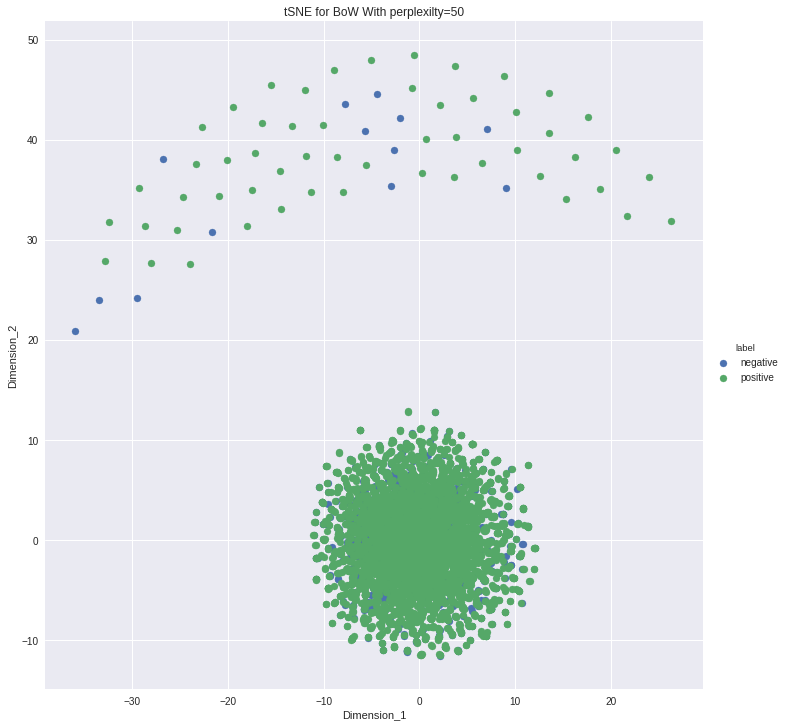

In [79]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2 , random_state=None , perplexity=50 , n_iter=750)

tsne_bow_data = model.fit_transform(final_counts)
label = final_subset['Score']
print(tsne_bow_data.shape)
print(label.shape)


tsne_bow_data=np.vstack((tsne_bow_data.T,label)).T
tsne_df=pd.DataFrame(data=tsne_bow_data,columns=("Dimension_1","Dimension_2","label"))

#Plotting the 2D TSNE results:
sns.FacetGrid(tsne_df,hue='label',size=10).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.title('tSNE for BoW With perplexilty=50')
plt.show()


In [125]:
#Let me calculate the Frequency Distribution of the words:

print('length of the positive words' ,len(all_positive_words))
print('length of the negative' ,len(all_negative_words))

freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)

print('Most Common positive words:' , freq_dist_positive.most_common(20))
print('Most Common neagtive words:' , freq_dist_negative.most_common(20))

length of the positive words 9299673
length of the negative 1814634
Most Common positive words: [(b'like', 117788), (b'tast', 110478), (b'good', 96771), (b'flavor', 95826), (b'love', 95821), (b'great', 91493), (b'use', 83676), (b'one', 80592), (b'product', 76477), (b'tea', 72948), (b'tri', 72059), (b'coffe', 70127), (b'make', 60772), (b'get', 60383), (b'food', 52072), (b'buy', 46893), (b'would', 46252), (b'time', 45948), (b'realli', 44598), (b'price', 43221)]
Most Common neagtive words: [(b'tast', 29483), (b'like', 27007), (b'product', 22509), (b'flavor', 16788), (b'one', 16695), (b'would', 14642), (b'tri', 14467), (b'coffe', 12578), (b'good', 12384), (b'use', 11966), (b'buy', 11452), (b'get', 11267), (b'order', 10722), (b'tea', 10091), (b'food', 9477), (b'even', 8953), (b'box', 8933), (b'bag', 8212), (b'amazon', 8037), (b'time', 7887)]


**Bi- Grams and n- Grams**

In [126]:
#Since in the above frequency distribution some words are same in the two freqdist so let's use bi grams and n- grams which 
# preserve the internal sequence information between the words which is detroyed in the case of uni grams/BoW.

#Creating the bi-Grams:
c_vector = CountVectorizer(ngram_range=(1,2) , min_df = 5)
final_counts_bigrams = c_vector.fit_transform(final_subset['CleanedText'].values)
print(final_counts_bigrams.get_shape())
print(type(final_counts_bigrams))
print(final_counts_bigrams.get_shape()[1])

(9804, 3818)
<class 'scipy.sparse.csr.csr_matrix'>
3818


**TFIDF VECTOR **

In [159]:
#Uni Gram gram Tf-IDF Vector
tfidf_vector = TfidfVectorizer(ngram_range=(1,1) , min_df=5 )
tfidf_count_values = tfidf_vector.fit_transform(final_subset['CleanedText'].values)
print(type(tfidf_count_values))
print(tfidf_count_values.get_shape())
print(tfidf_count_values.get_shape()[1])

<class 'scipy.sparse.csr.csr_matrix'>
(9804, 3818)
3818


In [0]:
# Before plotting the t-SNE plot we will perform TruncatedSVD operation for the TFIDF vector so as to perform 
# the dimensionality reduction:

# Create a TSVD with 1000 dimension :
tsvd = TruncatedSVD(n_components=2000)

# Conduct TSVD on sparse matrix final_counts:
tfidf_count_values = tsvd.fit(tfidf_count_values).transform(tfidf_count_values)

In [0]:
#Scaling
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
tfidf_standard = scaler.fit_transform(tfidf_count_values)

**Plotting the tSNE Plot for the Uni-gram TFIDF Vector**

(9804, 2)
(9804,)


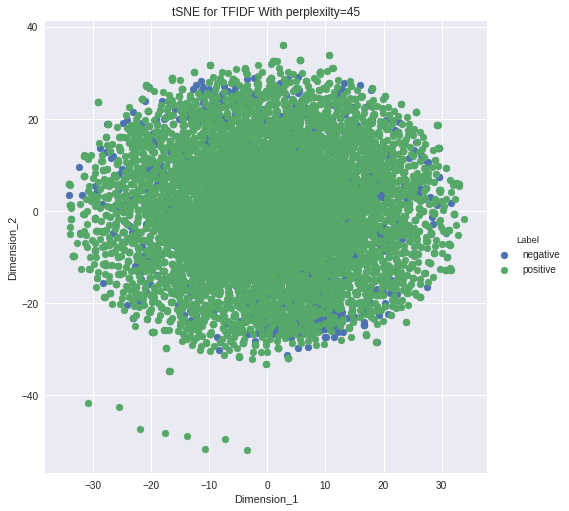

In [164]:
#tSNE plot:-

model = TSNE(n_components=2 , random_state=None , perplexity=45 , n_iter=750)

tsne_data = model.fit_transform(tfidf_standard)
label = final_subset['Score']
print(tsne_data.shape)
print(label.shape)


tsne_data=np.vstack((tsne_data.T,label)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=("Dimension_1","Dimension_2","Label"))

#Plotting the 2D TSNE results:
sns.FacetGrid(tsne_df,hue='Label',size=7).map(plt.scatter,'Dimension_1','Dimension_2').add_legend()
plt.title('tSNE for TFIDF With perplexilty=45')
plt.show()

In [128]:
#Lets get the vaues of the features of some indexes in the sparse tf_idf vector:

features = tfidf_vector.get_feature_names()
print(features[500:580])


['caribou', 'carmel', 'carnivor', 'carolina', 'carousel', 'carpet', 'carri', 'carrot', 'cart', 'carton', 'case', 'casein', 'cashew', 'casserol', 'cat', 'catch', 'categori', 'caught', 'cauliflow', 'caus', 'caution', 'cautious', 'caveat', 'caviar', 'cayenn', 'celeri', 'celesti', 'celiac', 'cell', 'cellophan', 'cent', 'center', 'cereal', 'certain', 'certif', 'certifi', 'ceylon', 'chai', 'chain', 'chalki', 'challeng', 'chamomil', 'chanc', 'chang', 'charact', 'charg', 'charm', 'chase', 'cheap', 'cheaper', 'cheapest', 'cheat', 'check', 'cheddar', 'cheer', 'cheerio', 'chees', 'cheesecak', 'cheesi', 'cheeto', 'chef', 'chemic', 'cherri', 'chest', 'chew', 'chewer', 'chewi', 'chewier', 'chex', 'chia', 'chicago', 'chicken', 'chickpea', 'chicori', 'chihuahua', 'child', 'childhood', 'children', 'chile', 'chili']


In [129]:
# Now we will Train our own model using Word2vec:
list_of_sentence=[]
for sent in final_subset['CleanedText'].values:
    list_of_sentence.append(sent.split())
print(final_subset['CleanedText'].values[0])
print(list_of_sentence[0])


flavor terribl love rest vita coco flavor one plain bad stay away
['flavor', 'terribl', 'love', 'rest', 'vita', 'coco', 'flavor', 'one', 'plain', 'bad', 'stay', 'away']


In [0]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=50 , workers=4)

In [147]:
model.wv.similarity('man' , 'woman')

0.9807813

In [148]:
model.wv.most_similar('tasti')

[('satisfi', 0.9764166474342346),
 ('yummi', 0.9697563648223877),
 ('salti', 0.9646331667900085),
 ('crunchi', 0.9633920788764954),
 ('over', 0.9565836191177368),
 ('crunch', 0.952536940574646),
 ('tooth', 0.9462743997573853),
 ('delici', 0.9444952607154846),
 ('balanc', 0.9421396851539612),
 ('crave', 0.9387975335121155)]

In [149]:
#Let's get our trained model vocabulary:

vocab_list = list(model.wv.vocab)
print("Words that exist more than 5 times are :" , len(vocab_list))
print(vocab_list[0:60])

Words that exist more than 5 times are : 4127
['flavor', 'terribl', 'love', 'rest', 'vita', 'coco', 'one', 'plain', 'bad', 'stay', 'away', 'ship', 'fast', 'custom', 'servic', 'excel', 'disappoint', 'product', 'claim', 'give', 'energi', 'reduc', 'appetit', 'yet', 'drink', 'tea', 'never', 'experienc', 'decreas', 'buy', 'mom', 'bought', 'went', 'bottl', 'lot', 'expens', 'far', 'could', 'tell', 'improv', 'health', 'way', 'dollar', 'may', 'notic', 'boost', 'although', 'experi', 'worth', 'huge', 'amount', 'money', 'peopl', 'rope', 'pay', 'also', 'seem', 'mind', 'tast', 'tri']


**Avg W2V **

In [167]:
#Computing the Average word2vec:
sent_vect= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence):
    sen_vec = np.zeros(50) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect.append(sen_vec)

print(len(sent_vect))

print(len(sent_vect[0]))
        

100%|██████████| 9804/9804 [00:10<00:00, 895.44it/s]

9804
50


In [168]:
#Converting the list type to array type of sent_vect we computed:
sent_vect = np.array(sent_vect)
type(sent_vect)

numpy.ndarray

**tSNE Plotting of the Avg W2V :**

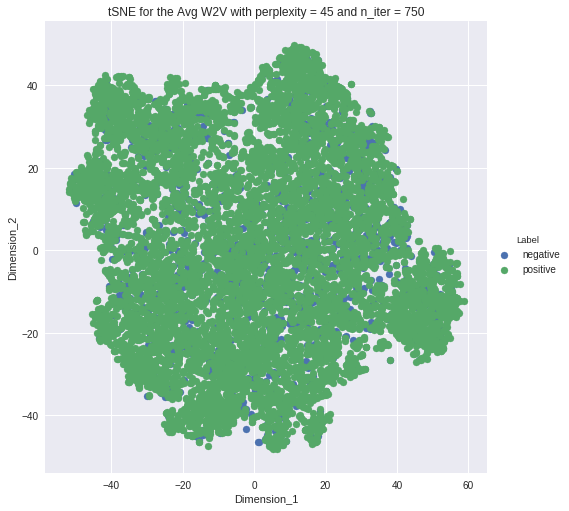

In [169]:
# Let's plot the t-SNE plot the average word to vector :
# here we have computed all the sentences as the vector using the avgw2v algorithm

model = TSNE(n_components=2 , random_state=None , perplexity = 45 , n_iter =750)

#Let's fit the standardised data into the tsne model:

scaled_vectors = StandardScaler().fit_transform(sent_vect)

#Since all the vectors are densed so there is no need of TruncatedSVD

tsne_data = model.fit_transform(scaled_vectors)
label = final_subset["Score"]
tsne_data = np.vstack((tsne_data.T , label)).T

tsne_df = pd.DataFrame(data=tsne_data , columns=['Dimension_1' , 'Dimension_2', 'Label' ])

#Plotting the tsne data of Avg W2V in 2D:

sns.FacetGrid(tsne_df , hue='Label' , size=7).map(plt.scatter , 'Dimension_1' , 'Dimension_2').add_legend()
plt.title("tSNE for the Avg W2V with perplexity = 45 and n_iter = 750")
plt.show()


**TFIDF AVG W2V**

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(final_subset['CleanedText'].values)
# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [0]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=50 , workers=4)

In [173]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors))

print(len(tfidf_sent_vectors[0]))

100%|██████████| 9804/9804 [00:14<00:00, 690.80it/s]


 9804
50


In [174]:
#Converting thr list to array type of the tfidf_sent_vectors:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
type(tfidf_sent_vectors)

numpy.ndarray

**tSNE Plotting of the TFIDF-W2V vector using the Standardized data:**

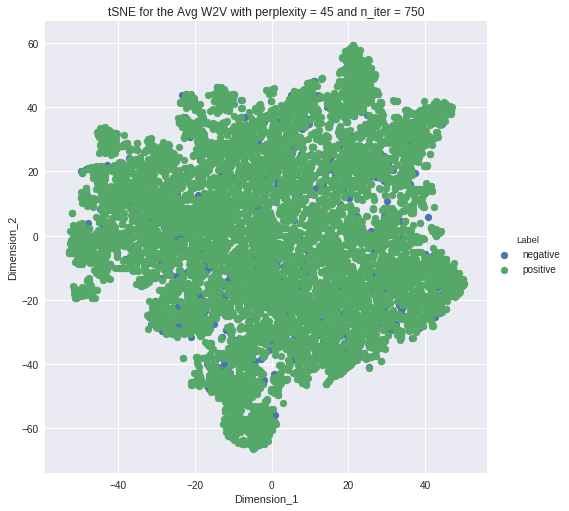

In [175]:
# Let's plot the t-SNE plot the average word to vector :
# here we have computed all the sentences as the vector using the avgw2v algorithm

model = TSNE(n_components=2 , random_state=None , perplexity = 45 , n_iter =750)

#Let's fit the standardised data into the tsne model:

scaled_vectors = StandardScaler().fit_transform(tfidf_sent_vectors)

#Since all the vectors are densed so there is no need of TruncatedSVD

tsne_data = model.fit_transform(scaled_vectors)
label = final_subset["Score"]
tsne_data = np.vstack((tsne_data.T , label)).T

tsne_df = pd.DataFrame(data=tsne_data , columns=['Dimension_1' , 'Dimension_2', 'Label' ])

#Plotting the tsne data of Avg W2V in 2D:

sns.FacetGrid(tsne_df , hue='Label' , size=7).map(plt.scatter , 'Dimension_1' , 'Dimension_2').add_legend()
plt.title("tSNE for the Avg W2V with perplexity = 45 and n_iter = 750")
plt.show()
